<a href="https://colab.research.google.com/github/trashchenkov/gigachat_tutorials/blob/main/LLM_%2B_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание бота с Vision
Значительную часть информации из окружающего мира мы привыкли получать через зрение. Традиционные же большие языковые модели работают исключительно с текстовой информацией. Чтобы это исправить, создают модели со способностью распознавать и анализировать изображения. К числу подобных относятся GPT-4 Vision (и более новые модели от OpenAI), семейство LLAVA, а также семейство Moondream. Модель moondream2 мы и будем использовать в связке с GigaChat.

Сама по себе moondream2 является _"small vision language model"_, но у нее плохо с русским, поэтому мы используем GigaChat в качестве переводчика.

## Общая схема проекта

В этом туториале мы сделаем TG-бота, который будет работать следующим образом:
- Пользователь отправляет сообщение боту. Это может быть текстовое сообщение или картинка с подписью. Например, можно отправить фото с вопросом "Какого цвета цветы на фото?".
- Для обработки изображений и текста в боте предусмотрены отдельные функции обработки.
    - Текстовые сообщения просто передаются в GigaChat. Ответ модели сохраняется в памяти `ConversationBufferMemory`, а также возвращается в виде ответа бота пользователю.
    - Сообщение с изображением проходит другую обработку. Если у изображения есть текстовое дополнение (с точки зрения Telegram оно считается caption), то его нужно перевести на английский. Если не содержит, то в качестве текстового промпта для moondream2 используем фразу "What do you see?". Изображение и текстовый промпт передадим в moondream2. Модель moondream2 выдаст ответ на английском. Его переведет GigaChat, чтобы этот перевод записать в память `ConversationBufferMemory` и отправить пользователю.

Что в истории сообщений `ConversationBufferMemory` будут храниться только тексты запросов пользователя и ответы GigaChat на русском. Изображения и ответы moondream2 не сохраняются в нашей программе.

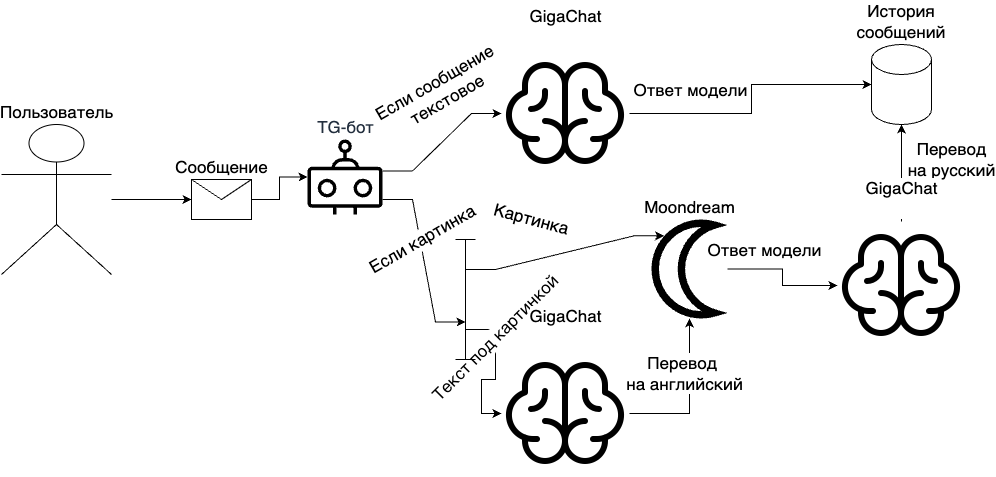

ВНИМАНИЕ: Сегодняшний туториал запускает код локально, но через интерфейс Google Colab. Поэтому мы будем следовать определенным шагам.

1. Создадим виртуальное окружение и установим в него [Jupyter Notebook](https://pypi.org/project/notebook/).
2. Активируем окружение.
3. Сохраняем credentials для GigaChat и ТГ-бота.
4. Подключаем Google Colab к локальной среде [по инструкции](https://research.google.com/colaboratory/local-runtimes.html).

## Описание moondream2
### Модель moondream2
Модель [moondream2](https://github.com/vikhyat/moondream) является небольшой (1,7 GB в установленном виде в Ollama), но способной вести диалог, принимать на вход текст и изображения, отвечая текстом на запросы пользователя.

Как работают такие модели?



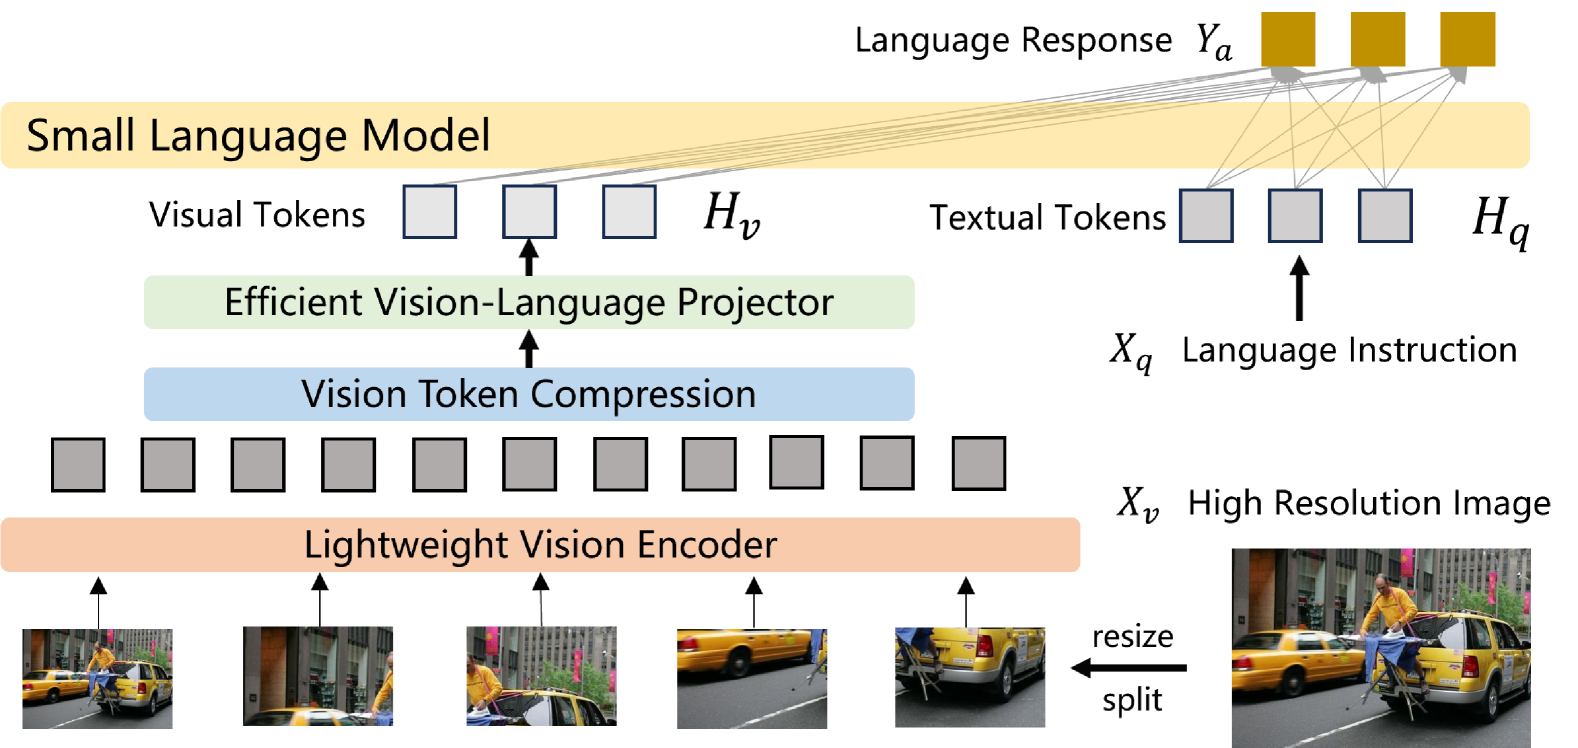

### Ollama
Чтобы запускать большие модели на пользовательских компьютерах, придумали специальные техники квантизации, когда, жертвуя точностью, добиваются существенного уменьшения размеров модели. В основе этого подхода находится инструмент llama.cpp, на использовании которого работают целый ряд программных решений для запуска больших языковых моделей: Ollama, LM Studio и другие.

Мы будем использовать [Ollama](https://ollama.com/), поскольку к Ollama есть подготовленная модель moondream2, поэтому установка и запуск не составят особого труда.

## Установка библиотек
Для туториала нам понадобятся следующие библиотеки:
- `ollama`
- `langchain`
- `langchain-community`
- `langchain-ollama`
- `pyTelegramBotAPI`
- `Pillow`


In [1]:
%pip install -q pyTelegramBotAPI langchain langchain-community ollama langchain-ollama
%pip install -q python-dotenv Pillow gigachat

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installa

## Подготовка изображения и инференс модели moondream2
### Преобразование в base64
Чтобы передать изображение модели нужно преобразовать его в текст с помощью `base64`. Для этого загружаем изображение из файла с помощью `Pillow`.


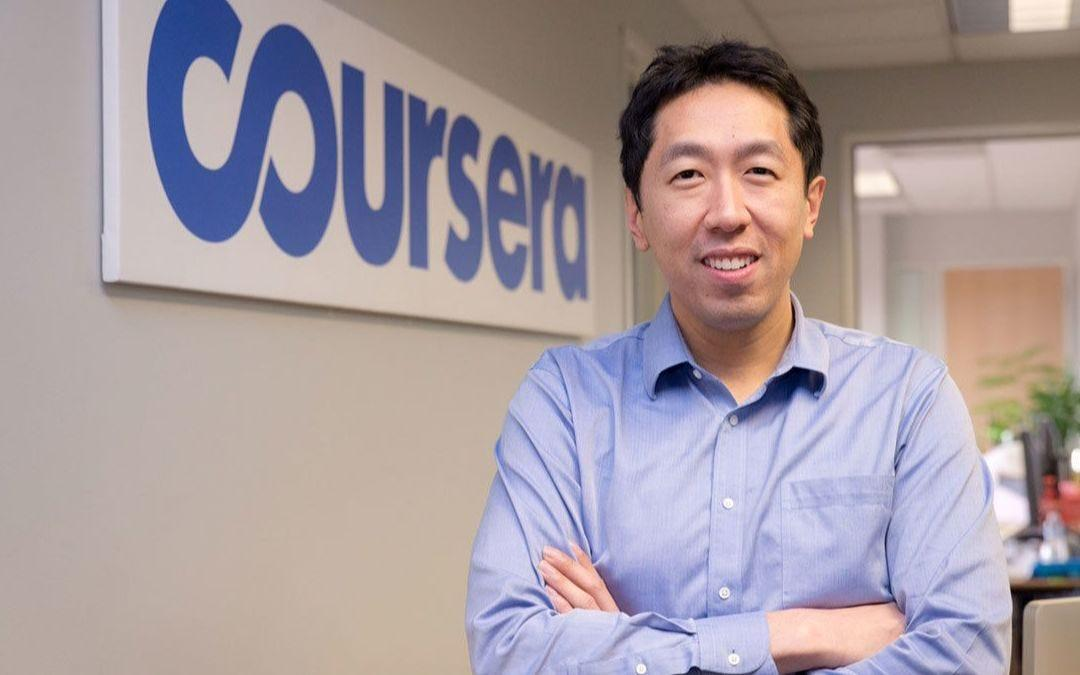

In [9]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = '1_GPas2MBwIQDzkDkDxMNI9w.jpg'
#file_path = '_MG_5844.jpg'
#file_path = 'photo_2024-08-03 16.43.46.jpeg'

pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

Теперь, когда изображение переведено в base64, можно передать его модели. Чтобы получать на выходе только текст ответа модели, используем `StrOutputParser`.

### Чат с моделью через Ollama
Для взаимодействия с моделью нам понадобятся компоненты `ChatOllama` (есть еще `OllamaLLM`, но он у меня не работает корректно с Vision, вопреки документации), `HumanMessage` и `StrOutputParser`.

`HumanMessage` позволяет в качестве содержимого передавать словарь, включающий изображение в формате base64 и текст.  

Создадим функцию, которая будет формировать такое пользовательское сообщение.

Из этой функции, подключения к Ollama и парсера `StrOutputParser` соберем цепочку.

In [5]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

In [16]:
llm = ChatOllama(model="moondream", temperature=0.2)


def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]




chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "What do you see?", "image": image_b64}
)

print(query_chain)


The image shows a man standing in front of a building. The man is wearing a white shirt and black pants, which are the main focus of the image. There are no other people or objects visible in the picture.


Протестируем еще на одном изображении.

In [11]:
file_path = '_MG_5844.jpg'
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)

In [12]:
chain.invoke(
    {"text": "What do you see?", "image": image_b64})

'\nThe image features a mannequin wearing a white shirt and black pants. The mannequin is standing upright, with its arms and legs spread out in front of it. It appears to be dressed for colder weather conditions, as the outfit consists mainly of long sleeves and pants.'

Убедившись, что модель работает как надо, можно теперь создать цепочку с переводом промптов и ответов модели.

## Сборка GigaChat и Moondream2  в единую цепочку
Загрузим авторизационные данные для GigaChat API.

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()
giga = os.getenv('GIGA')


Подключимся к GigaChat API.

In [14]:
from langchain_community.chat_models import GigaChat

chat = GigaChat(verify_ssl_certs=False, scope="GIGACHAT_API_PERS", credentials=giga)

Напишем функцию перевода с русского на английский. Проверим, что будет отвечать Moondream2 на запросы по-русски (то есть без этой функции).

In [17]:
from langchain_core.prompts import ChatPromptTemplate

def ru_en_prompt(text):
    prompt = ChatPromptTemplate.from_template("""Переведи следующий текст с русского на английский. \
    В качестве ответа дай только сам перевод без каких-либо дополнительных пояснений.
    Текст:
    {ru_text}""")
    translator = prompt | chat | StrOutputParser()

    return translator.invoke({'ru_text': text})


chain.invoke(
    {"text": "Опиши подробно, что видишь.", "image": image_b64})

'символ для прочта когда была в нейки интерпавши при помощь за получения движения кобазов на просто из полного споска.\n'

Раз с русским текстом модель работать не хочет, добавим перевод.

In [18]:
chain.invoke(
    {"text": ru_en_prompt("Опиши подробно людей. Передай все детали внешности."), "image": image_b64})

'\nThe image shows a man and woman standing in front of a building. The man is wearing a suit, while the woman has on a dress. They are both looking at something off-camera.'

Отлично! Теперь осталось сделать так, чтобы ответы Moondream2 тоже переводились на русский.

In [19]:
def en_ru_prompt(text):
    prompt = ChatPromptTemplate.from_template("""Переведи следующий текст с английского на русский. \
    В качестве ответа дай только сам перевод без каких-либо дополнительных пояснений.
    Текст:
    {en_text}""")
    translator = prompt | chat | StrOutputParser()

    return translator.invoke({'en_text': text})

In [20]:
full_chain = chain | en_ru_prompt

In [21]:
full_chain.invoke(
     {"text": ru_en_prompt("Опиши подробно людей. Передай все детали внешности."), "image": image_b64}
)

'Изображение показывает человека в белой рубашке и синих брюках.'

Чтобы обращаться к модели Moondream2 с отдельными сообщениями каждый раз, и диалог не сохранялся, напишем функцию, которая собирает цепочку каждый раз.

In [22]:
def work_w_vision(image, text='What do you see? Describe in details.'):
    llm = ChatOllama(model="moondream", temperature=0)
    chain = prompt_func | llm | StrOutputParser()
    full_chain = chain | en_ru_prompt
    answer = full_chain.invoke(
        {'text': text,
         'image': image}
    )
    return answer


Теперь у нас все готово для создания TG-бота.
## Обработка пользовательских сообщений Telegram-ботом

В этот раз для простоты мы опять сделаем синхронного бота. Асинхронному боту мы уделим отдельное видео.

In [23]:
import telebot
import requests
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, AIMessage


token = os.getenv('BOT')


Чтобы бот был многопользовательским, а диалоги не смешивались, будем хранить их в словаре (ключом будет id пользователя в Telegram).

In [24]:
# Словарь для хранения ConversationBufferMemory каждого пользователя
user_conversations = {}

In [25]:
conversation = ConversationChain(llm=chat,
                                 verbose=True,
                                 memory=ConversationBufferMemory())

/opt/homebrew/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  warn_deprecated(


Создаем бота.

In [28]:
bot = telebot.TeleBot(token)

In [29]:
# Функция для обработки изображений
@bot.message_handler(content_types=['photo'])
def image_recognition(message):
    file_info = bot.get_file(message.photo[-1].file_id)
    file_path = file_info.file_path
    file_url = f'https://api.telegram.org/file/bot{token}/{file_path}'
    user_id = message.from_user.id
    response = requests.get(file_url)
    if response.status_code == 200:
        if user_id not in user_conversations:
            user_conversations[user_id] = ConversationBufferMemory()
        # Обновление конфигурации ConversationChain для текущего пользователя
        conversation.memory = user_conversations[user_id]
        # Преобразование файла в base64
        img_base64 = base64.b64encode(response.content).decode('utf-8')
        caption = message.caption
        if caption != None:
            answer = work_w_vision(img_base64, ru_en_prompt(caption))
        else:
            answer = work_w_vision(img_base64)
            caption = 'Что ты видишь на фото?'

        bot.send_message(user_id, answer)
        conversation.memory.chat_memory.add_user_message(message=caption)
        conversation.memory.chat_memory.add_ai_message(message=answer)
    else:
        bot.send_message(user_id, 'Возникли проблемы с распознавание изображения. Попробуйте еще раз.')

# Функция для автоматического ответа в случае если сообщение не текст и не фото
@bot.message_handler(content_types=['audio',
                                    'video',
                                    'document',
                                    'sticker',
                                    'voice',
                                    'location',
                                    'contact'])
def not_text_or_photo(message):
  user_id = message.chat.id
  bot.send_message(user_id, 'Я работаю только с текстовыми сообщениями и изображениями!')


# Функция, обрабатывающая текстовые сообщения
@bot.message_handler(content_types=['text'])
def handle_text_message(message):
    user_id = message.chat.id

    # Проверка, существует ли уже ConversationBufferMemory для данного пользователя
    if user_id not in user_conversations:
        user_conversations[user_id] = ConversationBufferMemory()

    # Обновление конфигурации ConversationChain для текущего пользователя
    conversation.memory = user_conversations[user_id]

    # Получение и отправка ответа через GigaChat
    response = conversation.predict(input=message.text)
    bot.send_message(user_id, conversation.memory.chat_memory.messages[-1].content)


bot.infinity_polling()

2024-08-06 16:06:23,366 (__init__.py:1095 MainThread) ERROR - TeleBot: "Infinity polling exception: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))"
2024-08-06 16:06:23,379 (__init__.py:1097 MainThread) ERROR - TeleBot: "Exception traceback:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/opt/homebrew/lib/python3.9/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/opt/homebrew/lib/python3.9/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/http/client.py", line 1377, in getresponse
    response.begin()
  File "/opt/homebrew/Cellar/python@3.9/3.9.17_1/Frameworks/Py



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Привет, расскажи о себе!
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Привет, расскажи о себе!
AI: Конечно! Я - генеративная языковая модель, созданная с использованием передовых технологий искусственного интеллекта. Моя цель - помогать людям, предоставляя информацию и ответы на их вопросы. Я могу говорить на русском языке и имею доступ к огромному количеству

2024-08-06 17:07:33,755 (__init__.py:1101 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
2024-08-06 17:07:33,773 (__init__.py:1103 MainThread) ERROR - TeleBot: "Break infinity polling"
